# Behaviour Tree

For more information, visit: [Documentation](https://py-trees.readthedocs.io/en/devel/) and [Github](https://github.com/splintered-reality/py_trees/blob/devel/README.md)

<center>
<img src="img/sample_tree.webp" width="400"/>
</center>

## Behaviours (Action Node)

A Behaviour is the smallest element in a behaviour tree, i.e. it is the leaf. Behaviours are usually representative of either a check (am I hungry?), or an action (buy some chocolate cookies).


<center>
<img src="img/leaf.png" />
</center>

## Type of composites (Control Nodes):

<center>
<img src="img/composites.png" width="500"/>
</center>


- [Selector](https://py-trees.readthedocs.io/en/devel/composites.html#selector): execute a child based on cascading priorities
- [Sequence](https://py-trees.readthedocs.io/en/devel/composites.html#sequence): execute children sequentially
- [Parallel](https://py-trees.readthedocs.io/en/devel/composites.html#parallel): execute children concurrently


### Selector

A selector is a composite node that ticks each child in order until one of them returns success. As soon as a child succeeds, the selector stops and returns success; if none do, it returns failure.

### Sequence

A sequence ticks its children one after the other. If any child fails, the sequence immediately stops and returns failure; only if all children succeed does it return success.


### Parallel

A parallel composite ticks all its children concurrently. Its outcome is determined by configurable thresholds: it returns success if enough children succeed, and failure if too many fail.

[Policies](https://py-trees.readthedocs.io/en/devel/modules.html#py_trees.common.ParallelPolicy): 
- SuccessOnAll
- SuccessOnOne
- SuccessOnSelected

# Getting Started

In [6]:

# Install py_trees
%pip install py_trees

# For visualization
%pip install pydot

# Note: You'll need graphviz installed on your system for visualization

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [25]:
import py_trees
import time

# for visualization
from IPython.display import Image, display

## Simple Tree with one Leaf Node

[ INFO] AlwaysSuccess        : Always returning SUCCESS
Writing /home/andri/repos/getting_started_py_tree/alwayssuccess.dot
Writing /home/andri/repos/getting_started_py_tree/alwayssuccess.png
Writing /home/andri/repos/getting_started_py_tree/alwayssuccess.svg


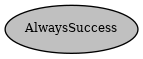

In [22]:
# Create a simple behavior that always succeeds
class AlwaysSuccess(py_trees.behaviour.Behaviour):
    def __init__(self, name="AlwaysSuccess"):
        super(AlwaysSuccess, self).__init__(name)
    
    def update(self):
        # This behavior always returns SUCCESS
        self.logger.info("Always returning SUCCESS")
        return py_trees.common.Status.SUCCESS

# Create an instance of our behavior
always_success = AlwaysSuccess()

# Set up the tree
root = always_success

# Create and setup the behavior tree
behavior_tree = py_trees.trees.BehaviourTree(root)

# Execute the tree once
behavior_tree.tick()

# Display the state of the tree
img = py_trees.display.render_dot_tree(root)
display(Image(data=img["png"]))

Writing /home/andri/repos/getting_started_py_tree/root_selector.dot
Writing /home/andri/repos/getting_started_py_tree/root_selector.png
Writing /home/andri/repos/getting_started_py_tree/root_selector.svg


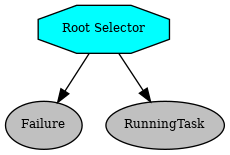

[ INFO] Failure              : Always returning FAILURE
[ INFO] RunningTask          : Still running, 2.00 seconds remaining
[ INFO] Failure              : Always returning FAILURE
[ INFO] RunningTask          : Still running, 1.00 seconds remaining
[ INFO] Failure              : Always returning FAILURE
[ INFO] RunningTask          : Finished running, returning SUCCESS


In [39]:
# A behavior that always fails
class AlwaysFail(py_trees.behaviour.Behaviour):
    def __init__(self, name="AlwaysFail"):
        super(AlwaysFail, self).__init__(name)
    
    def update(self):
        self.logger.info("Always returning FAILURE")
        return py_trees.common.Status.FAILURE

# A behavior that runs for a while before succeeding
class RunningThenSuccess(py_trees.behaviour.Behaviour):
    def __init__(self, name="RunningThenSuccess", duration=3):
        super(RunningThenSuccess, self).__init__(name)
        self.duration = duration
        self.start_time = None

    def initialise(self):
        self.start_time = time.time()
    
    def update(self):
        if time.time() - self.start_time > self.duration:
            self.logger.info("Finished running, returning SUCCESS")
            return py_trees.common.Status.SUCCESS
        else:
            remaining = self.duration - (time.time() - self.start_time)
            self.logger.info(f"Still running, {remaining:.2f} seconds remaining")
            return py_trees.common.Status.RUNNING

# Create instances
always_fail = AlwaysFail("Failure")
running_then_success = RunningThenSuccess("RunningTask", 2)

# Try to use a Sequence instead of a Selector
root = py_trees.composites.Selector("Root Selector", memory=False)
#root = py_trees.composites.Sequence("Root Selector", memory=False)

root.add_children([always_fail, running_then_success])

# Create and setup the behavior tree
behavior_tree = py_trees.trees.BehaviourTree(root)


img = py_trees.display.render_dot_tree(root)
display(Image(data=img["png"]))

# Execute the tree three times 
for i in range(3):
    behavior_tree.tick()
    time.sleep(1)

## More complex tree

[o] RobotBehavior
    [-] TaskSequence
        --> CheckBattery
        --> PerformTask
    [-] RechargeSequence
        --> FindCharger
        --> MoveToCharger
        --> Recharge

Writing /home/andri/repos/getting_started_py_tree/robotbehavior.dot
Writing /home/andri/repos/getting_started_py_tree/robotbehavior.png
Writing /home/andri/repos/getting_started_py_tree/robotbehavior.svg


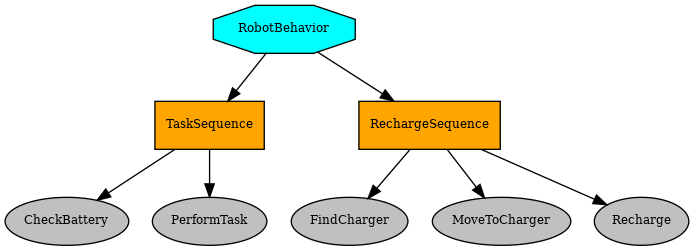

In [40]:
# Behaviors for our robot
class CheckBatteryLevel(py_trees.behaviour.Behaviour):
    def __init__(self, name="CheckBattery", threshold=30):
        super(CheckBatteryLevel, self).__init__(name)
        self.threshold = threshold
        self.blackboard = py_trees.blackboard.Blackboard()
        # Initialize battery level if not set
        if not self.blackboard.exists('battery_level'):
            self.blackboard.set('battery_level', 75)

    def update(self):
        battery_level = self.blackboard.get('battery_level')
        self.logger.info(f"Battery level: {battery_level}%")
        
        # Decrease battery by 5-15% each time
        battery_level -= random.randint(5, 15)
        battery_level = max(0, battery_level)  # Don't go below 0
        self.blackboard.set('battery_level', battery_level)
        
        if battery_level <= self.threshold:
            return py_trees.common.Status.FAILURE  # Battery low
        else:
            return py_trees.common.Status.SUCCESS  # Battery OK

class FindChargingStation(py_trees.behaviour.Behaviour):
    def __init__(self, name="FindCharger"):
        super(FindChargingStation, self).__init__(name)
        self.blackboard = py_trees.blackboard.Blackboard()
    
    def update(self):
        self.logger.info("Searching for charging station...")
        # Simulate finding the charging station
        self.blackboard.set('charger_found', True)
        return py_trees.common.Status.SUCCESS

class MoveToChargingStation(py_trees.behaviour.Behaviour):
    def __init__(self, name="MoveToCharger", duration=2):
        super(MoveToChargingStation, self).__init__(name)
        self.duration = duration
        self.start_time = None
        self.blackboard = py_trees.blackboard.Blackboard()
    
    def initialise(self):
        self.start_time = time.time()
    
    def update(self):
        if not self.blackboard.get('charger_found', False):
            self.logger.info("No charging station found!")
            return py_trees.common.Status.FAILURE
        
        if time.time() - self.start_time > self.duration:
            self.logger.info("Arrived at charging station")
            return py_trees.common.Status.SUCCESS
        else:
            self.logger.info("Moving to charging station...")
            return py_trees.common.Status.RUNNING

class Recharge(py_trees.behaviour.Behaviour):
    def __init__(self, name="Recharge", duration=3):
        super(Recharge, self).__init__(name)
        self.duration = duration
        self.start_time = None
        self.blackboard = py_trees.blackboard.Blackboard()
    
    def initialise(self):
        self.start_time = time.time()
    
    def update(self):
        if time.time() - self.start_time > self.duration:
            self.logger.info("Fully recharged!")
            self.blackboard.set('battery_level', 100)
            return py_trees.common.Status.SUCCESS
        else:
            current_level = self.blackboard.get('battery_level')
            # Increase battery by 10% each update
            new_level = min(100, current_level + 10)
            self.blackboard.set('battery_level', new_level)
            self.logger.info(f"Recharging... Battery level: {new_level}%")
            return py_trees.common.Status.RUNNING

class PerformTask(py_trees.behaviour.Behaviour):
    def __init__(self, name="PerformTask"):
        super(PerformTask, self).__init__(name)
    
    def update(self):
        self.logger.info("Performing the main task!")
        return py_trees.common.Status.SUCCESS

# Set up the robot behavior tree
root = py_trees.composites.Selector("RobotBehavior", memory=False)

# Main task sequence - check battery then do the task
task_sequence = py_trees.composites.Sequence("TaskSequence", memory=False)
task_sequence.add_children([
    CheckBatteryLevel(threshold=30),
    PerformTask()
])

# Recharging sequence
recharge_sequence = py_trees.composites.Sequence("RechargeSequence", memory=False)
recharge_sequence.add_children([
    FindChargingStation(),
    MoveToChargingStation(duration=1),
    Recharge(duration=2)
])

# Add both sequences to the root selector
# The selector will try the task first, but if battery is low (task fails),
# it will try to recharge instead
root.add_children([
    task_sequence,
    recharge_sequence
])

# Create the behavior tree
robot_tree = py_trees.trees.BehaviourTree(root)

# Display the tree structure
print(py_trees.display.ascii_tree(root))

img = py_trees.display.render_dot_tree(root)
display(Image(data=img["png"]))